In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

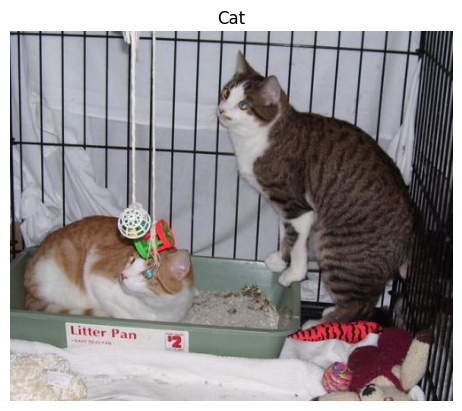

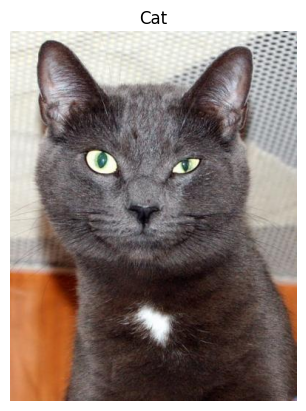

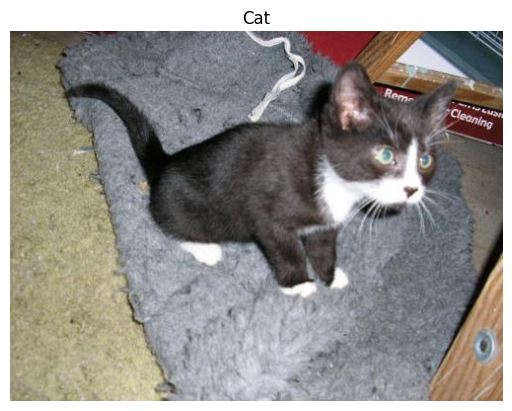

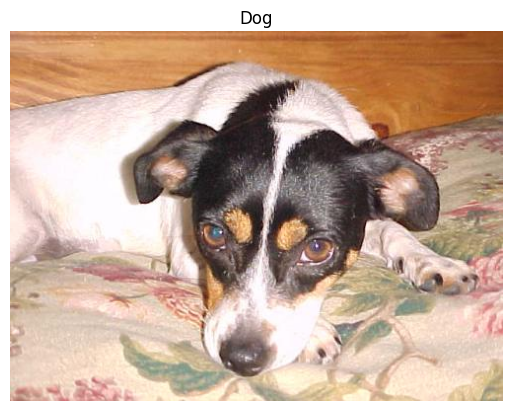

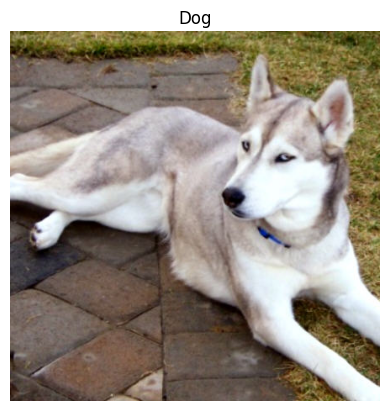

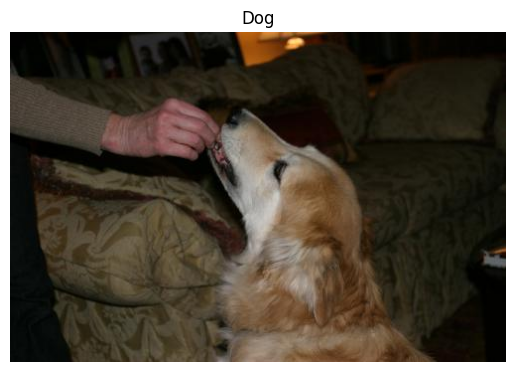

In [2]:
# cesta k obrázkům
base_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
categories = ["Cat", "Dog"]

# zobrazit 3 obrázky od každé kategorie
for label in categories:
    folder = os.path.join(base_path, label)
    shown = 0
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(label)
            plt.axis("off")
            plt.show()
            shown += 1
            if shown == 3:
                break
        except:
            continue

In [3]:
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        for idx, label in enumerate(["Cat", "Dog"]):
            folder = os.path.join(root_dir, label)
            for filename in os.listdir(folder)[:1000]:
                path = os.path.join(folder, filename)
                try:
                    with Image.open(path) as img:
                        img.verify() # ověření obrázku
                    self.images.append(path)
                    self.labels.append(idx)
                except:
                    continue

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]
        
                    

Label: Cat


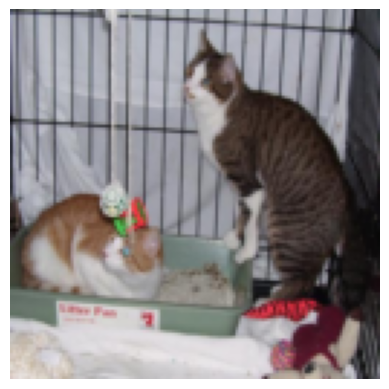

In [4]:
# transformace pro obrazky
transform = transforms.Compose([
    transforms.Resize((128,128)), # změna velikost na 128x128
    transforms.ToTensor(), # převod na tensor
])

#vytvoření instance datasetu
dataset = CatsDogsDataset(base_path, transform=transform)

#zobrazení 1 obrázku z datasetu
img, label = dataset[0]
print(f"Label: {'Cat' if label == 0 else 'Dog'}")
plt.imshow(np.transpose(img.numpy(), (1,2,0))) # převedení tensoru zpět na obraz
plt.axis("off")
plt.show()

In [5]:
from torch.utils.data import DataLoader

# vytvoření DataLoaderu
train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,           # doporučené maximum
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3,16, kernel_size=3, padding=1), # vstip RGB 3 kanály
            nn.ReLU(),
            nn.MaxPool2d(2), # změnšit velikost na polovinu

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(), # převod na 1D
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64,2) # 2 výstupy = Kočka nebo Pes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

In [8]:
img, _ = dataset[0]
img = img.unsqueeze(0).to(device) 
output = model(img)
print("model output:", output)

model output: tensor([[ 0.0667, -0.1377]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
# ztratova funkce pro klasifikaci
criterion = nn.CrossEntropyLoss()

# optimilizator
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 5  # kolikrát projdeme celý dataset

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()  # vymažeme předchozí gradienty
        loss.backward()        # spočítáme nové gradienty
        optimizer.step()       # aktualizujeme parametry

        running_loss += loss.item()

        # výpočet přesnosti
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/5, Loss: 46.0144, Accuracy: 53.85%
Epoch 2/5, Loss: 42.5070, Accuracy: 57.95%
Epoch 3/5, Loss: 41.2465, Accuracy: 61.10%
Epoch 4/5, Loss: 39.0693, Accuracy: 66.05%
Epoch 5/5, Loss: 36.1555, Accuracy: 70.90%


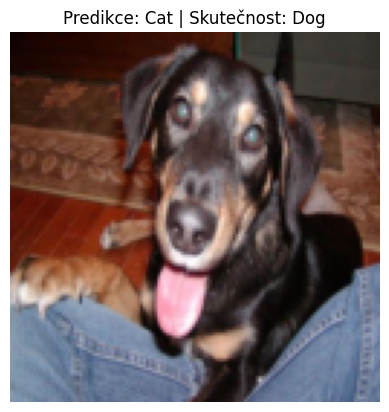

In [11]:
from random import randint

idx = randint(0, len(dataset) - 1)
img, label = dataset[idx]
img_tensor = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    predicted = torch.argmax(output, dim=1).item()

plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(f"Predikce: {'Cat' if predicted == 0 else 'Dog'} | Skutečnost: {'Cat' if label == 0 else 'Dog'}")
plt.axis("off")
plt.show()